
Sample Scraped Jobs
                               Title            Company        Location     Posted                                                     Skills
              Senior Elixir Engineer Sanctuary Computer     🌏 Worldwide 2025-08-13                [ruby, django, javascript, node.js, python]
                  FullStack Engineer       NTD software 💃 Latin America 2025-08-12                           [react, devops, css, javascript]
                    Mobile Developer   The Biz Conquest 💃 Latin America 2025-08-10                                                         []
Javascript Fullstack Engineer Senior          Lumenalta     🌏 Worldwide 2025-08-07                                               [javascript]
          Senior Full Stack Engineer            FetLife     🌏 Worldwide 2025-08-06 [ruby, sql, typescript, javascript, terraform, kubernetes]
      Senior Python Backend Engineer            Orga AI     🌏 Worldwide 2025-07-26                                             

/tmp/ipython-input-2033335122.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=skill_counts.values, y=skill_counts.index, palette="mako")


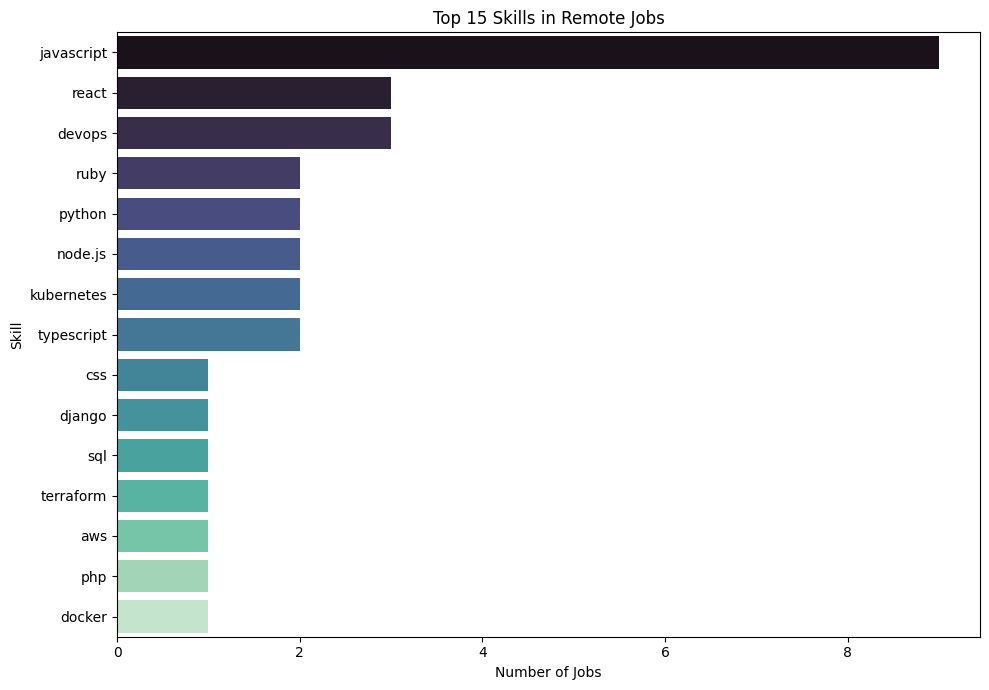

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 127759 (\N{EARTH GLOBE ASIA-AUSTRALIA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128131 (\N{DANCER}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12

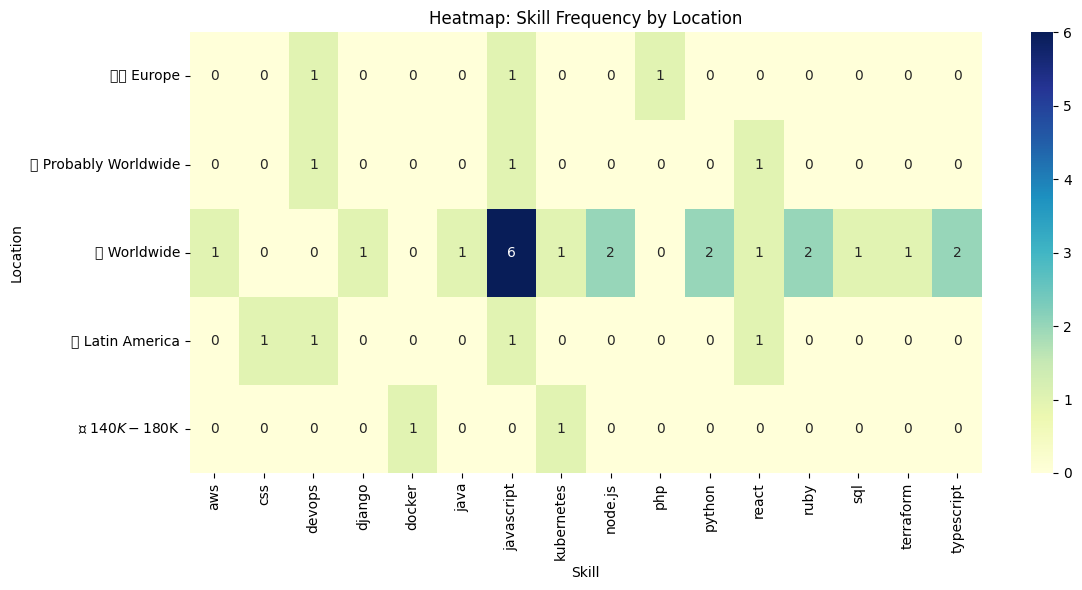

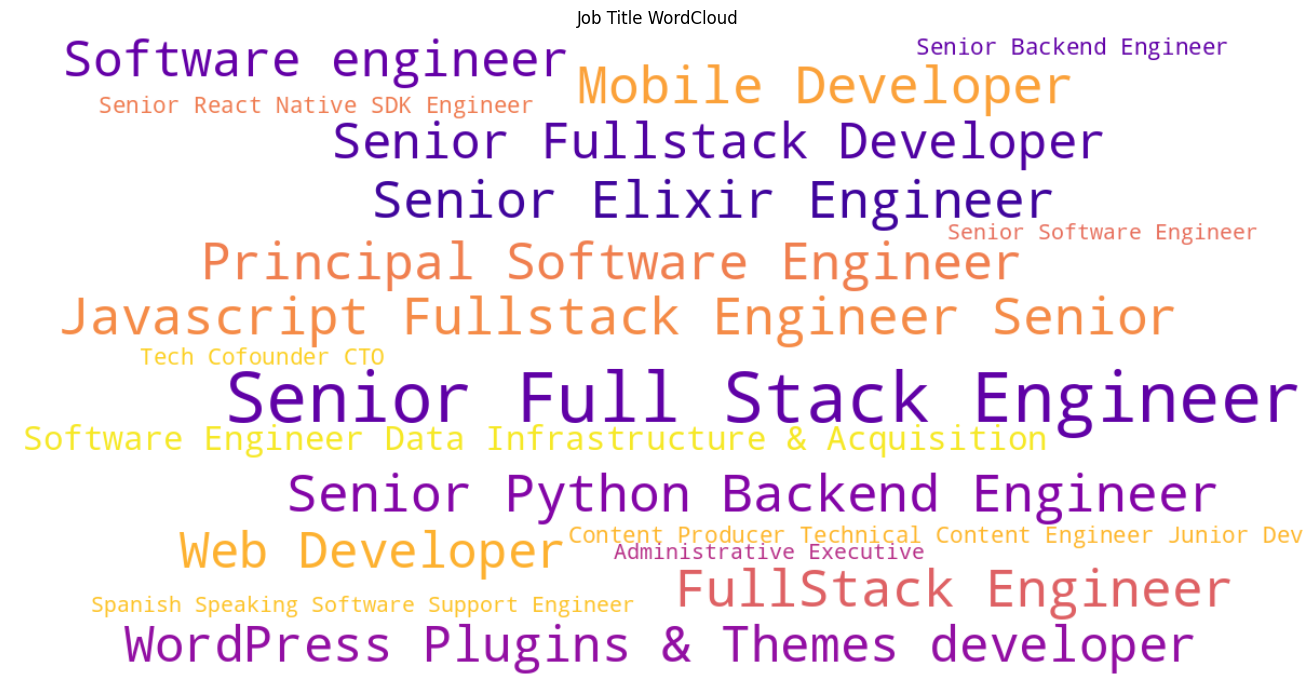


Top terms per cluster:
Cluster 0: developer, mobile, web, cofounder, tech, cto, wordpress, themes, plugins, speaking
Cluster 1: engineer, software, senior, backend, elixir, principal, python, native, react, sdk
Cluster 2: fullstack, engineer, senior, content, javascript, developer, producer, junior, dev, technical
Cluster 3: stack, senior, engineer, themes, web, wordpress, tech, support, speaking, spanish
Cluster 4: administrative, executive, wordpress, themes, web, technical, tech, speaking, spanish, support


In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import logging
import re
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud, STOPWORDS
from pathlib import Path
from collections import Counter
from difflib import get_close_matches

# Config
BASE_URL = "https://remoteok.com/remote-dev-jobs"
HEADERS = {"User-Agent": "Mozilla/5.0"}
PAGE_LIMIT = 3
REQUEST_DELAY = 1.5
MAX_JOBS = 150

# Skills and synonyms
SKILLS = [
    "python", "javascript", "react", "node.js", "docker", "aws", "sql",
    "css", "html", "java", "c++", "kubernetes", "typescript", "graphql",
    "machine learning", "data science", "linux", "terraform", "azure",
    "devops", "rest api", "flutter", "ruby", "django", "php"
]
SKILL_SYNONYMS = {
    "js": "javascript",
    "py": "python",
    "ml": "machine learning",
    "aws cloud": "aws",
    "typescript": "typescript",
    "reactjs": "react",
    "node": "node.js",
    "restapi": "rest api",
}

# Location mapping + fuzzy tolerance
LOCATION_MAP = {
    "nyc": "New York",
    "new york, ny": "New York",
    "usa": "USA",
    "united states": "USA",
    "remote": "Remote",
}

STOP_SKILLS = {"new", "senior", "remote", "full-time", "contract"}

# Setup logging
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

# Helper functions
def normalize_skill(skill):
    skill = skill.lower()
    skill = SKILL_SYNONYMS.get(skill, skill)
    skill = re.sub(r"[^a-z0-9\s\.]", "", skill).strip()
    return skill

def normalize_location(loc):
    loc = loc.lower().strip()
    if loc in LOCATION_MAP:
        return LOCATION_MAP[loc]
    close = get_close_matches(loc, LOCATION_MAP.keys(), n=1, cutoff=0.8)
    if close:
        return LOCATION_MAP[close[0]]
    return loc.title()

def extract_skills(tags):
    skills = []
    for t in tags:
        t_norm = normalize_skill(t)
        if t_norm and t_norm not in STOP_SKILLS and t_norm in SKILLS:
            skills.append(t_norm)
    return list(set(skills))

def fetch_page(url):
    try:
        resp = requests.get(url, headers=HEADERS)
        resp.raise_for_status()
        return BeautifulSoup(resp.text, "html.parser")
    except Exception as e:
        logging.error(f"Error fetching {url}: {e}")
        return None

def parse_job(row):
    try:
        title = row.find("h2").get_text(strip=True) if row.find("h2") else ""
        company = row.find("h3").get_text(strip=True) if row.find("h3") else ""
        location = row.find("div", class_="location")
        location = normalize_location(location.get_text(strip=True)) if location else "Remote"
        tags = [t.get_text(strip=True) for t in row.find_all("div", class_="tag")]
        posted_raw = row.find("time").get("datetime") if row.find("time") else None
        posted = datetime.fromisoformat(posted_raw).date() if posted_raw else None
        skills = extract_skills(tags)
        return {
            "Title": title,
            "Company": company,
            "Location": location,
            "Posted": posted,
            "Skills": skills
        }
    except Exception as e:
        logging.warning(f"Failed to parse job row: {e}")
        return None

def scrape_jobs():
    jobs = []
    page = 1
    while len(jobs) < MAX_JOBS and page <= PAGE_LIMIT:
        url = f"{BASE_URL}?page={page}"
        logging.info(f"Scraping page {page} ...")
        soup = fetch_page(url)
        if not soup:
            break
        rows = soup.find_all("tr", class_="job")
        for r in rows:
            if len(jobs) >= MAX_JOBS:
                break
            job = parse_job(r)
            if job:
                jobs.append(job)
        page += 1
        time.sleep(REQUEST_DELAY)

    df = pd.DataFrame(jobs)
    df.drop_duplicates(subset=["Title", "Company", "Location", "Posted"], inplace=True)
    return df

# Analysis & Visualizations

def print_summary_table(df):
    print("\nSample Scraped Jobs")
    print(df.head(10).to_string(index=False))

def plot_top_skills(df):
    df_exp = df.explode("Skills")
    skill_counts = df_exp["Skills"].value_counts().head(15)

    plt.figure(figsize=(10, 7))
    sns.barplot(x=skill_counts.values, y=skill_counts.index, palette="mako")
    plt.title("Top 15 Skills in Remote Jobs")
    plt.xlabel("Number of Jobs")
    plt.ylabel("Skill")
    plt.tight_layout()
    plt.show()

def plot_skills_by_location_heatmap(df):
    df_exp = df.explode("Skills")
    top_locations = df_exp["Location"].value_counts().head(5).index
    filtered = df_exp[df_exp["Location"].isin(top_locations)]

    pivot = pd.crosstab(filtered["Location"], filtered["Skills"])
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot, annot=True, fmt='d', cmap='YlGnBu')
    plt.title("Heatmap: Skill Frequency by Location")
    plt.ylabel("Location")
    plt.xlabel("Skill")
    plt.tight_layout()
    plt.show()

def plot_skill_trends(df):
    df_exp = df.explode("Skills")
    df_exp = df_exp.dropna(subset=["Posted"])
    if df_exp.empty:
        logging.info("No posted dates available for trend plot.")
        return

    # Group by posted date and skill counts
    trend_data = df_exp.groupby(["Posted", "Skills"]).size().unstack(fill_value=0)
    trend_data = trend_data[top_skills[:10]] if len(trend_data.columns) >= 10 else trend_data

    plt.figure(figsize=(14, 7))
    trend_data.rolling(window=3).mean().plot()
    plt.title("Skill Trends Over Time (Rolling Avg)")
    plt.xlabel("Posted Date")
    plt.ylabel("Job Count")
    plt.legend(title="Skills")
    plt.tight_layout()
    plt.show()

def generate_colored_wordcloud(df):
    title_freq = df["Title"].value_counts().to_dict()
    wc = WordCloud(
        width=1200,
        height=600,
        background_color="white",
        colormap="plasma",
        stopwords=set(STOPWORDS),
        max_words=150,
        contour_color='steelblue',
        contour_width=3,
    ).generate_from_frequencies(title_freq)

    plt.figure(figsize=(14, 7))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Job Title WordCloud")
    plt.tight_layout()
    plt.show()

def cluster_job_titles(df, n_clusters=5):
    titles = df["Title"].astype(str).values
    vect = TfidfVectorizer(stop_words="english", max_features=5000)
    X = vect.fit_transform(titles)
    km = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = km.fit_predict(X)
    df["Cluster"] = clusters

    # Show top keywords per cluster
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    terms = vect.get_feature_names_out()

    print("\nTop terms per cluster:")
    for i in range(n_clusters):
        top_terms = [terms[ind] for ind in order_centroids[i, :10]]
        print(f"Cluster {i}: {', '.join(top_terms)}")

    return df

def main():
    df = scrape_jobs()
    if df.empty:
        logging.error("No jobs scraped. Exiting.")
        return

    print_summary_table(df)
    plot_top_skills(df)
    plot_skills_by_location_heatmap(df)
    generate_colored_wordcloud(df)

    df = cluster_job_titles(df)
    df.to_csv("jobs_clustered.csv", index=False)
    logging.info(f"Saved clustered jobs to jobs_clustered.csv")

if __name__ == "__main__":
    main()
